**NOTE!** The code uses processed data from the LHCb experiment. Collaboration members please write nikita.kazeev@cern.ch for access.

In [1]:
from deep_ensembles import nets, data
from deep_ensembles.params import *
from deep_ensembles.train import train, repeater, ParticleSet


In [ ]:
!wget <data> && unzip -qq rich.zip


In [7]:
data_dir = 'rich'
import os
import numpy as np

def get_particle_dset(particle):
    return [os.path.join(data_dir, name) for name in os.listdir(data_dir) if particle in name]

datasets = {particle: get_particle_dset(particle) for particle in PARTICLES} 

In [8]:
data_train, data_val, _, data_train_s, data_val_s, data_test_s, scaler = data.get_val_dataset(datasets, PARTICLE_TYPE, dtype=np.float32, log=True)

Reading and concatenating datasets:
	rich/pion_-_up_2016_.csv
	rich/pion_+_down_2016_.csv
	rich/pion_+_up_2016_.csv
	rich/pion_-_down_2016_.csv
	rich/pion2_+_down_2016_.csv
	rich/pion2_+_up_2016_.csv
	rich/pion2_-_down_2016_.csv
	rich/pion2_-_up_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 1.5067942142486572
scaling train set
scaling val set
scaling val set
converting dtype to <class 'numpy.float32'>


In [133]:
mus, sigmas = [0, 1, 2, 3, 4], [0.1, 0.15, 0.2, 0.25, 0.3] # mean and standard deviation

def conditional_gan(x, trues=None, i=None):

    num_models = 10
    final_outputs = []
    for j in range(num_models):
        outputs = []
        for mu, sigma in zip(mus, sigmas):
            outputs.append(np.random.normal(mu, sigma + j * 0.01, x.shape[0]))
        final_outputs.append(np.stack(outputs, axis=1))
    if i is not None:
        return final_outputs[i]
    return final_outputs


In [118]:
import torch
size = int(2e5)

features = []
for idx in range(data_train_s.shape[1]):
    min_ = min(np.array(data_train_s)[:, idx].min(), np.array(data_train_s)[:, idx].min())
    max_ = max(np.array(data_train_s)[:, idx].max(), np.array(data_train_s)[:, idx].max())

    features.append(np.random.uniform(size=(size, 1), low=min_, high=max_))

feats_gen = torch.tensor(np.concatenate(features, axis=1))
feats_gen.shape

torch.Size([200000, 9])

In [119]:
X = []
st = []
stsy = []
ref_i = 9
num_models = 10
condition_dataset = np.concatenate([feats_gen[:, y_count:-1].float()])#, np.array(data_train_s)[:, y_count:-1]])
index = np.random.permutation(condition_dataset.shape[0])
condition_dataset = condition_dataset[index][:size, :]

for i in range(num_models):
    if i != ref_i:
        X.append (condition_dataset)
        st.append (np.abs(conditional_gan(condition_dataset, i=ref_i) - conditional_gan(condition_dataset, i=ref_i)))
        stsy.append (np.abs(conditional_gan(condition_dataset, i=i) - conditional_gan(condition_dataset, i=ref_i)))

X = np.concatenate(X)
st = np.concatenate(st)
stsy = np.concatenate(stsy)


In [120]:
st.shape

(1800000, 5)

In [121]:
def prepare(dset):
    return np.c_ [dset.T[0], dset.T[1], dset.T[2], dset.T[3], dset.T[4]]

n = len(X)

index = np.random.permutation(n)
X = X[index]
Y1 = prepare(st[index])
Y2 = prepare(stsy[index])

In [122]:
from sklearn.ensemble import RandomForestRegressor as RF
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.l1 = torch.nn.Linear(n_feature, n_hidden)  
        self.l2 = torch.nn.Linear(n_hidden, n_hidden)  
        self.l3 = torch.nn.Linear(n_hidden, n_hidden)
        self.relu = nn.LeakyReLU(0.1)  

        self.predict = torch.nn.Linear(n_hidden, n_output)  

    def forward(self, x):
        x = self.relu(self.l1(x)) 
        x = self.relu(self.l2(x)) 
        x = self.relu(self.l3(x)) 
        x = self.predict(x)   
        return x

def train_models(X, Y1, Y2, mode='rf'):
    assert(mode in ('rf', 'nn'))
    model1, model2 = None, None
    N = size * num_models
    #lr=1e-3, batch_size=int(1e5), epochs=20
    if mode == 'rf':
        model1 = RF(max_depth=3)
        model2 = RF(max_depth=3)

        model1.fit(np.c_[X[:N]], Y1[:N])
        model2.fit(np.c_[X[:N]], Y2[:N])

    else:    
        model1 = Net(n_feature=3, n_hidden=128, n_output=5)    
        model2 = Net(n_feature=3, n_hidden=128, n_output=5)   

    for model, y in [(model1, Y1), (model2, Y2)]:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_func = torch.nn.MSELoss()  
        batch_size=int(1e5)
        for t in tqdm(range(5)):
            idx = torch.randperm(X.shape[0])
            X = X[idx]
            y = y[idx]
            for i in range(0, X.shape[0], batch_size):
                batch = torch.tensor(X[i:i+batch_size]).float()
                batch_y = torch.tensor(y[i:i+batch_size]).float()
                pred = model(batch) 
                loss = loss_func(pred, batch_y)  
                optimizer.zero_grad()
                loss.backward()   
                optimizer.step()   

    return model1, model2

In [123]:
model1 = Net(n_feature=3, n_hidden=128, n_output=5)    
model2 = Net(n_feature=3, n_hidden=128, n_output=5)  
model1, model2 = train_models(X, Y1, Y2, mode='nn')

100%|██████████| 5/5 [00:35<00:00,  7.17s/it]


In [124]:
import matplotlib.pyplot as plt 
import pickle

with open("TEST_DATA_DLL.pkl", "rb") as tf:
    TEST_DATA = pickle.load(tf)
    
with open("random.pkl", "rb") as tf:
    random_test = pickle.load(tf)

In [125]:
def smoothen_values(x, y, num_points=200, spline_power=2):
    from scipy.interpolate import make_interp_spline

    xnew = np.linspace(min(x), max(x), num_points)
    spl = make_interp_spline(x, y, k=spline_power)
    ynew = spl(xnew)

    return xnew, ynew
def log10_inverse(x):
    return np.power(10, x) / 1000

In [126]:
c1 = (89., 89., 89.)
c2 = (255.,128.,14.)
c3= (0.,107.,164.,)
c4=(162.,200.,236.)
c5=(255.,188.,121.)
c6 = (200.,82.,0.)
colors= [c1, c2, c3, c4, c5, c6]
for i in range(6):
    colors[i] = tuple([ci/255 for ci in colors[i]])

In [127]:
def parse_momentum_inverse(data, log=True, momentum_idx=5):
    momentum = scaler.inverse_transform(data[:, :8])[:, momentum_idx]

    if log:
        momentum = np.log10(momentum)
    return momentum

In [128]:
font = {'family' : 'serif',
        'serif' : 'Times New Roman',
        'weight' : 400,
        'size'   : 28}
plt.rc('font', **font)


xtick = {'major.size' : 14,
         'minor.size' : 7,
         'major.width' : 1.5,
         'minor.width' : 1.5,
         #'labelsize': 30
         }

plt.rc('xtick', **xtick)

ytick = {'major.size' : 14,
        'minor.size' : 7,
        'major.width' : 1.5,
        'minor.width' : 1.5,
        'major.pad' : 10,
        'minor.pad' : 10,
        'labelsize': 30}
plt.rc('ytick', **ytick)

plt.style.use('tableau-colorblind10')
axes = {'labelsize':32,
        'linewidth': 2
}
plt.rc('axes', **axes)
plt.style.use('tableau-colorblind10')

n_bounds = 40

In [129]:
boundaries = np.array([3.07187843, 3.1460932 , 3.22030796, 3.29452273, 3.36873749,
       3.44295225, 3.51716702, 3.59138178, 3.66559655, 3.73981131,
       3.81402607, 3.88824084, 3.9624556 , 4.03667037, 4.11088513,
       4.1850999 , 4.25931466, 4.33352942, 4.40774419, 4.48195895,
       4.55617372, 4.63038848, 4.70460324, 4.77881801, 4.85303277,
       4.92724754, 5.0014623 , 5.07567706, 5.14989183, 5.22410659,
       5.29832136, 5.37253612, 5.44675089, 5.52096565, 5.59518041,
       5.66939518, 5.74360994, 5.81782471, 5.89203947, 5.96625423])

In [134]:
columns

NameError: name 'columns' is not defined

In [135]:
thresholds = []

for mu, sigma in zip(mus, sigmas):
    data = np.random.normal(mu, sigma + j * 0.01, 10000)
    thresholds.append(np.percentile(data, 10))


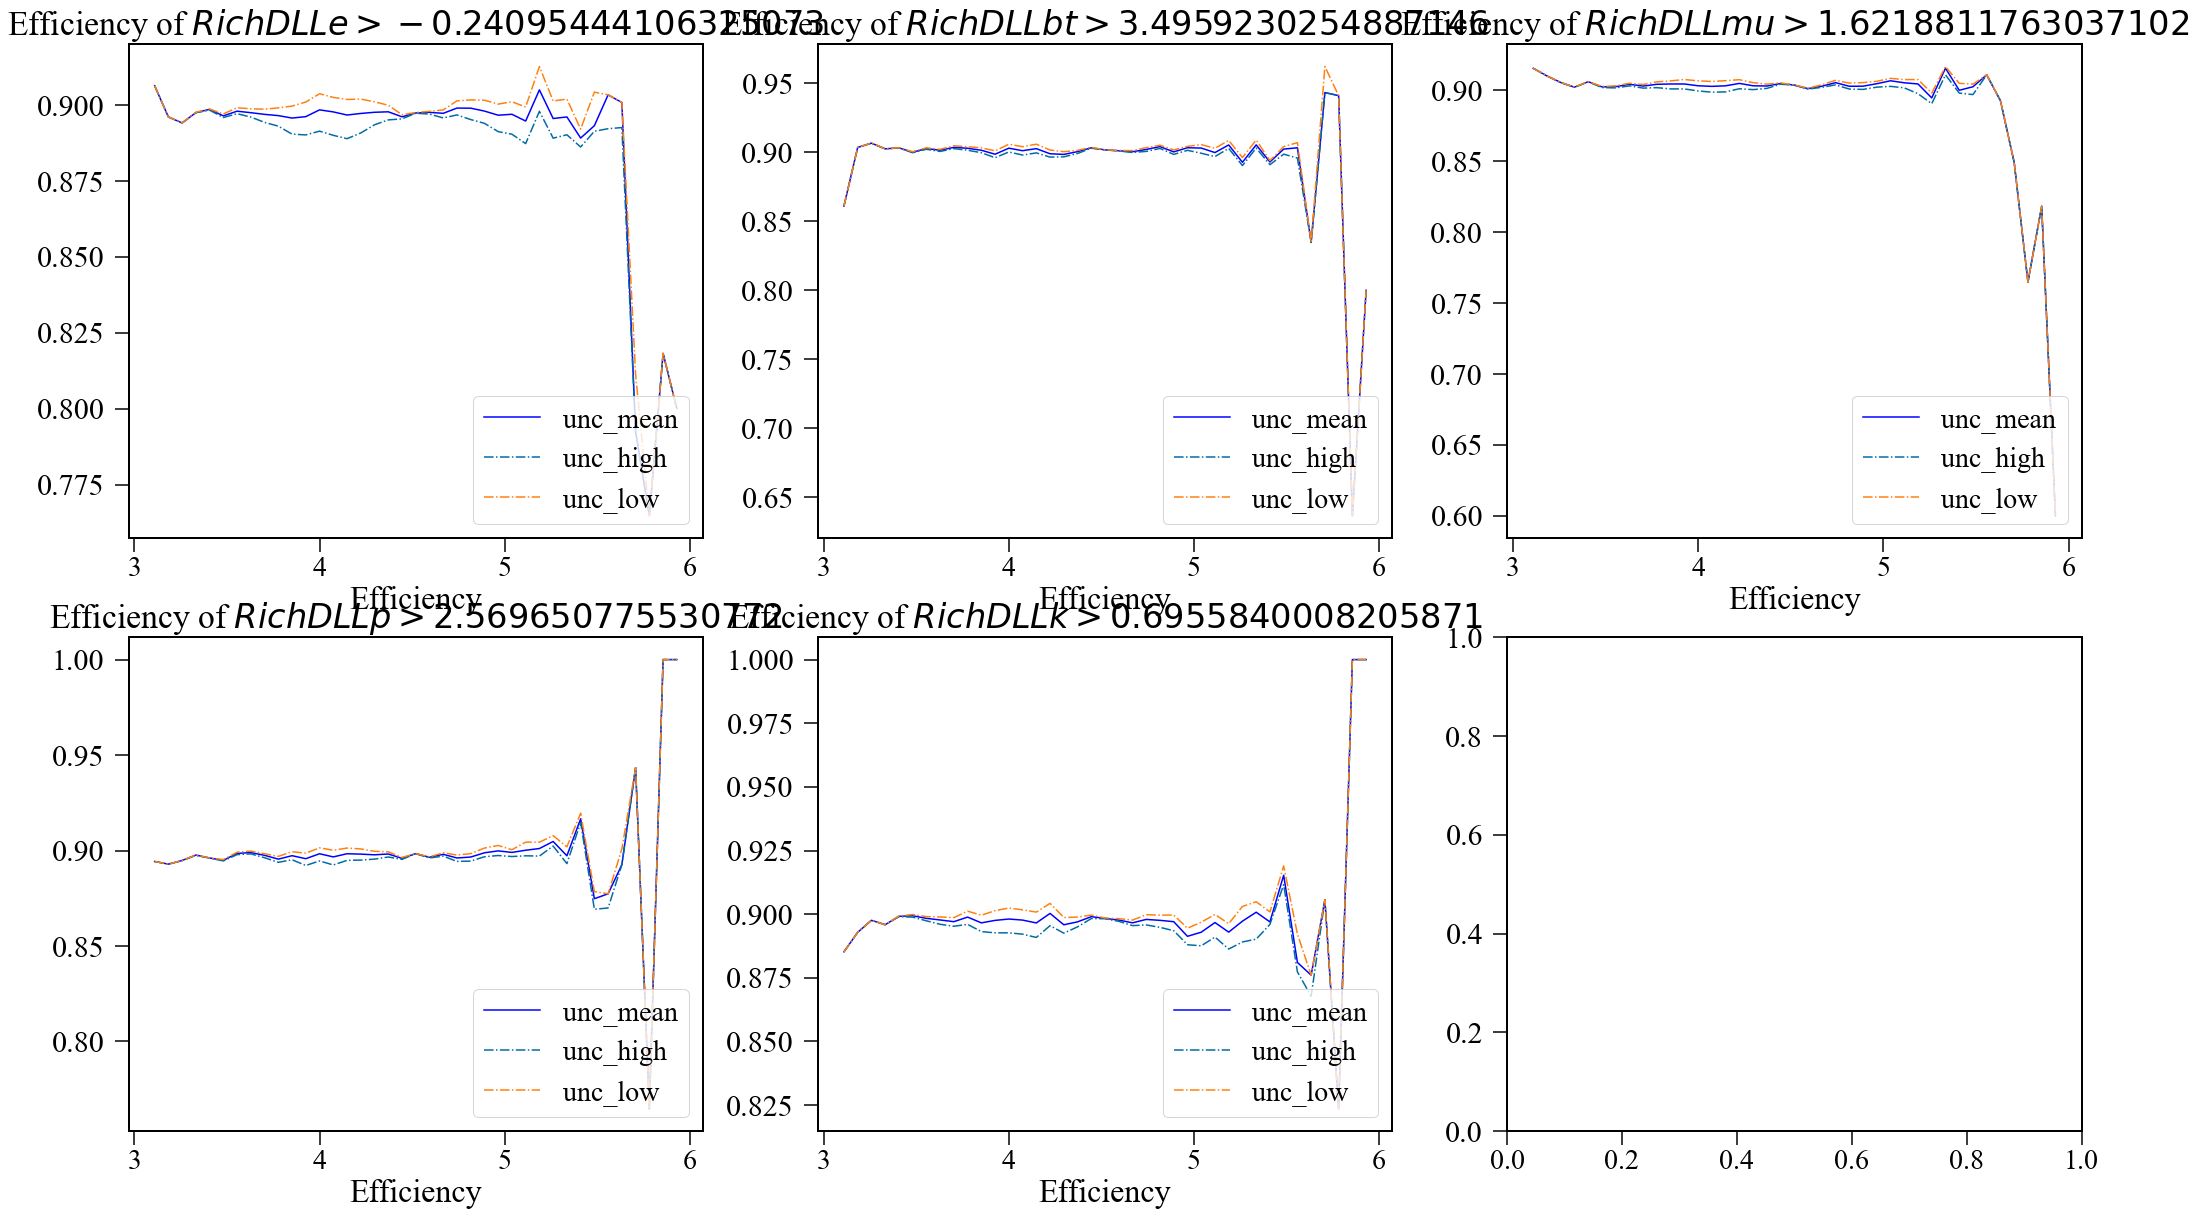

In [137]:
condition_dataset = np.array(data_val_s)
#x_boundaries = np.linspace(min(condition_dataset[:, 5]), max(condition_dataset[:, 5]), 40)
fig, ax = plt.subplots(2, 3, figsize=(35, 20))

momentum_val = parse_momentum_inverse(np.array(data_val_s), log=True)
momentum_val.min(), momentum_val.max()

for i in range(5):
    for j in range(10):
        eff = []
        err = []
        data_eff = []
        data_err = []
    xvalue = []
    eff_mean = []
    eff_high = []
    eff_low = []
    thr = thresholds[i]
    for xmin, xmax in zip(boundaries[:-1], boundaries[1:]):
        mask = (momentum_val > xmin) & (momentum_val < xmax)
        if np.count_nonzero(mask):
            ys = conditional_gan(condition_dataset[mask][:, y_count:-1], i=None)[9][:, i]        
            xvalue.append (0.5*(xmin + xmax))
            fs = condition_dataset[mask][:, y_count:-1]
            uncert = np.sqrt(np.maximum(0, np.square(model2(torch.tensor(np.c_[fs])).detach().numpy())/2 - 
                                          np.square(model1(torch.tensor(np.c_[fs])).detach().numpy())/2))
            n = np.count_nonzero(mask)
            eff_mean.append (np.count_nonzero(ys > thr)/n)
            eff_low.append (np.count_nonzero(ys + uncert[:,0] > thr)/n)
            eff_high.append (np.count_nonzero(ys - uncert[:,0] > thr)/n)

    ax[i % 2][i % 3].plot (xvalue, eff_mean, '-', label=f'unc_mean', color='blue')
    ax[i % 2][i % 3].plot (xvalue, eff_high, '-.', label=f'unc_high')
    ax[i % 2][i % 3].plot (xvalue, eff_low, '-.', label=f'unc_low')

    #ax[i].savefig(f'{PARTICLES[i]}.png', bbox_inches='tight')
    ax[i % 2][i % 3].title.set_text(f"Efficiency of ${dll_columns[i]} > {thr}$")
    ax[i % 2][i % 3].legend(loc='lower right')
    ax[i % 2][i % 3].set_xlabel("Momentum")
    ax[i % 2][i % 3].set_xlabel("Efficiency")
plt.show()